In [6]:
import os
import sys
import tempfile
import numpy as np
import h5py
import json 

import matplotlib.pyplot as plt

from datetime import datetime
import pandas as pd
from numpy.random import default_rng

import torch


In [7]:


def load_jsonl_to_dataframe(file_path):
    """
    Reads a .jsonl file line by line and loads it into a pandas DataFrame.

    Args:
        file_path (str): The path to the .jsonl file.

    Returns:
        pandas.DataFrame: A DataFrame containing the data from the file,
                          or None if the file is not found or is empty.
    """
    data_list = []
    try:
        # Open the file for reading. The 'with' statement ensures the file is properly closed.
        with open(file_path, 'r') as f:
            # Iterate over each line in the file.
            for line in f:
                # Each line is a JSON string, so we parse it into a dictionary
                # and append it to our list. We use strip() to remove any potential trailing newline characters.
                if line.strip():  # Ensure the line is not empty
                    try:
                        data_list.append(json.loads(line))
                    except json.JSONDecodeError as e:
                        print(f"Skipping line due to JSON decoding error: {e}")
                        print(f"Problematic line: {line.strip()}")

        # Create a pandas DataFrame from the list of dictionaries if data was loaded.
        if data_list:
            df = pd.DataFrame(data_list)
            return df
        else:
            print("No data was loaded. The file might be empty or all lines had errors.")
            return None

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        print("Please make sure the file exists and the path is correct.")
        return None


def read_record(record):
    """Reads a single line from the dataset."""
    radar_back_file = record["radar_file_path_back"]
    radar_back_future = record["radar_file_path_future"]

    gs_future = record["groundstation_file_path_future"]
    gs_back = record["groundstation_file_path_back"]

    height = record["ground_height_file_path"]
    landcover = record["landcover_file_path"]

    hour = record["hour"]
    minutes = record["minute"]
    time_radar_back = record["time_radar_back"]
    datetime = record["datetime"]
    id = record["id"]

    # Load the all the npz files
    npz_paths = [radar_back_file, radar_back_future, gs_future, gs_back, height]
    # Check if all files exist
    for npz_path in npz_paths:
        if not os.path.exists(npz_path):
            print(f"File not found: {npz_path}")
            continue
    # Load the npz files
    try:
        radar_back_data = np.load(radar_back_file)[
            "arr_0"
        ]  # Assuming the data is stored under 'arr_0'
        radar_future_data = np.load(radar_back_future)["arr_0"]
        gs_future_data = np.load(gs_future)["arr_0"]
        gs_back_data = np.load(gs_back)["arr_0"]
        height_data = np.load(height)["arr_0"]
        landcover_data = np.load(landcover)["arr_0"]
    except Exception as e:
        print(
            f"Error loading data from {radar_back_file}, {radar_back_future}, {gs_future}, {gs_back}, {height}: {e}"
        )
        raise ("Error")

    gs_back_data = np.where(gs_back_data == -100, -4, gs_back_data)
    gs_back_data = np.where(np.isnan(gs_back_data), -4, gs_back_data)

    gs_future_data = np.where(gs_future_data == -100, -4, gs_future_data)
    gs_future_data = np.where(np.isnan(gs_future_data), -4, gs_future_data)

    return {
        "radar_back": radar_back_data,  # The NumPy array itself
        "radar_future": radar_future_data,  # The NumPy array itself
        "groundstation_future": gs_future_data,  # The NumPy array itself
        "groundstation_back": gs_back_data,  # The NumPy array itself
        "ground_height": height_data,  # The NumPy array itself
        "landcover": landcover_data,
        "hour": hour / 24.,  # The scalar value
        "minute": minutes / 60.,  # The scalar value
        # "time_radar_back": time_radar_back,  # The scalar value
        # "datetime": datetime,  # The scalar value
        # "id": id,  # The scalar value
    }


class MeteoLibreDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, directory):
        super().__init__()

        self.directory = directory

        # index reader
        self.json_path = os.path.join(self.directory, "index.json")
        self.index_data = load_jsonl_to_dataframe(self.json_path)

        for columns in self.index_data.columns:
            if "file" in columns:
                self.index_data[columns] = directory + self.index_data[columns].str[19:]

    def __len__(self):
        return len(self.index_data)

    def __getitem__(self, item):
        row = self.index_data.iloc[item]

        # read data
        data = read_record(row)

        return data

In [8]:
dataset = MeteoLibreDataset(directory="/home/adrienbufort/meteolibre_dataset/data/hf_dataset/")


Skipping line due to JSON decoding error: Expecting value: line 1 column 1 (char 0)
Problematic line:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [16]:
data = dataset[2000]
print(data.keys())

dict_keys(['radar_back', 'radar_future', 'groundstation_future', 'groundstation_back', 'ground_height', 'landcover', 'hour', 'minute'])


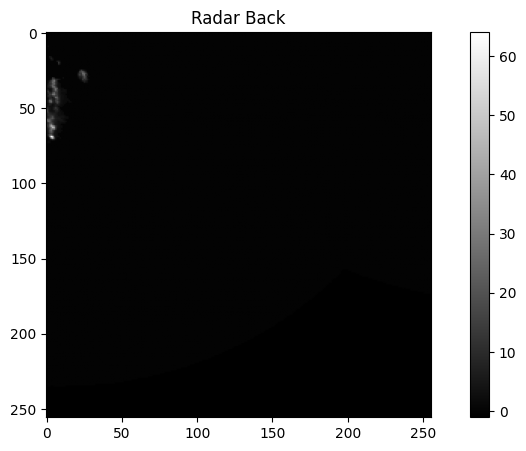

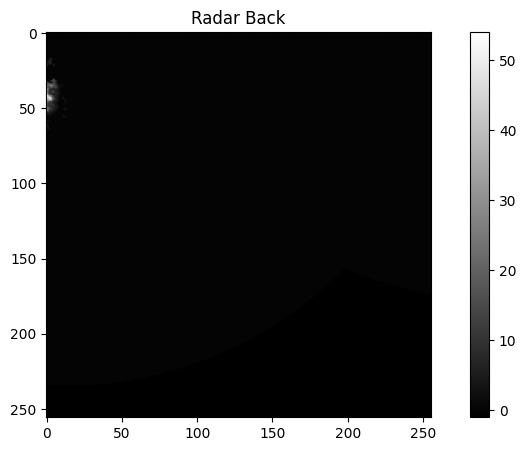

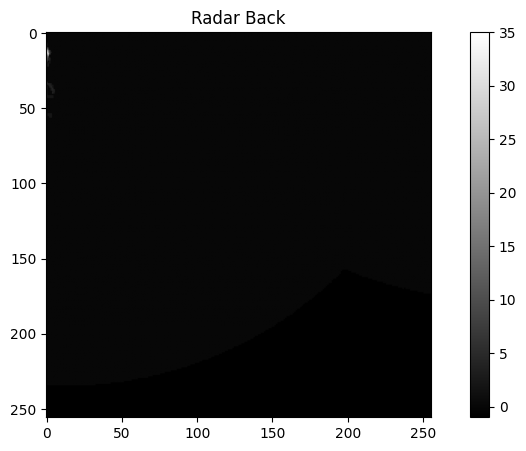

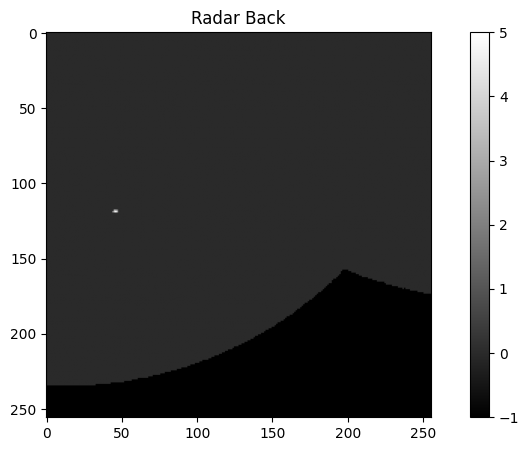

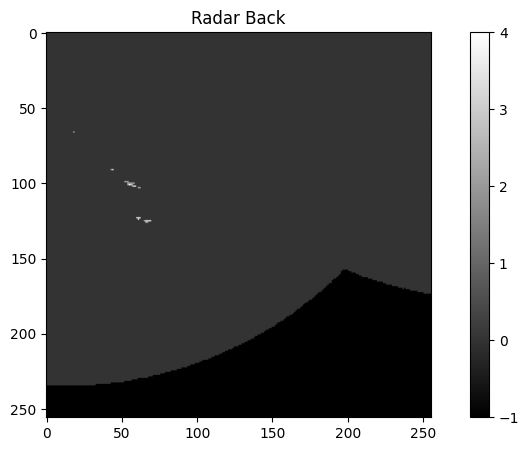

In [17]:
radar_back = data['radar_back'] * 60


# we plot the radar_back and the radar_future
for i in range(radar_back.shape[0]):
    plt.figure(figsize=(10, 5))
    plt.imshow(radar_back[i], cmap='gray')
    plt.title('Radar Back')
    plt.colorbar()

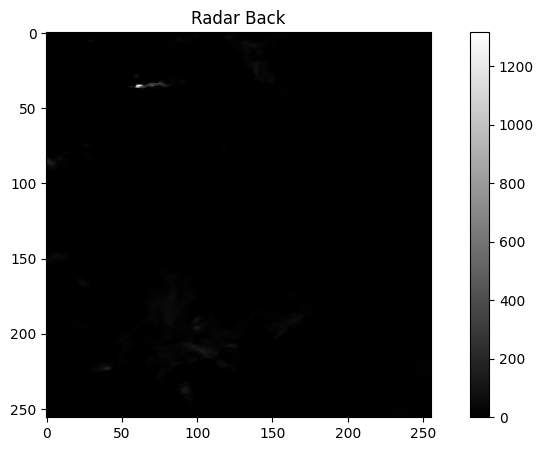

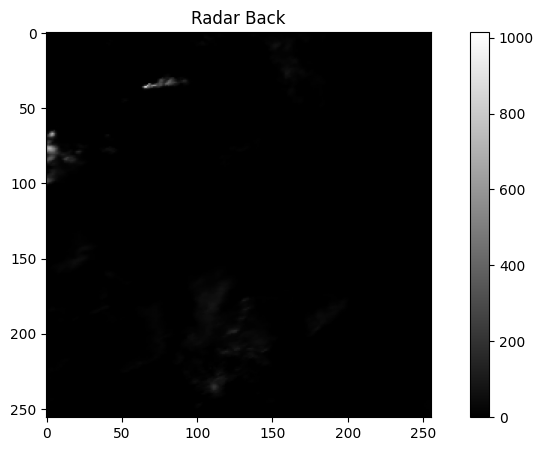

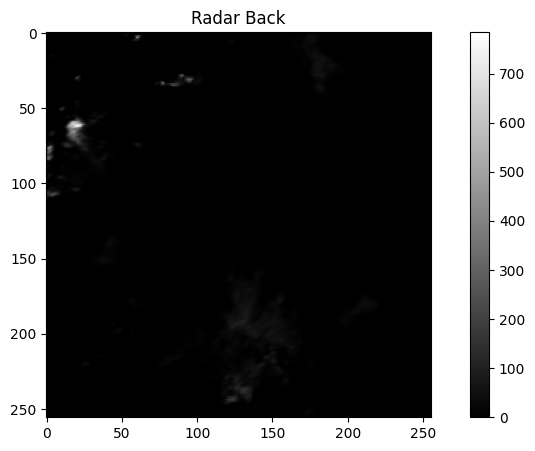

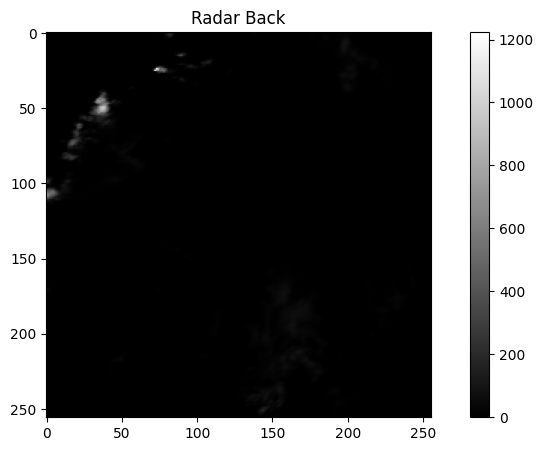

In [11]:
radar_future = data['radar_future'] * 60


# we plot the radar_future and the radar_future
for i in range(radar_future.shape[0]):
    plt.figure(figsize=(10, 5))
    plt.imshow(radar_future[i], cmap='gray')
    plt.title('Radar Back')
    plt.colorbar()

In [13]:
radar_future.shape

(5, 256, 256, 7)

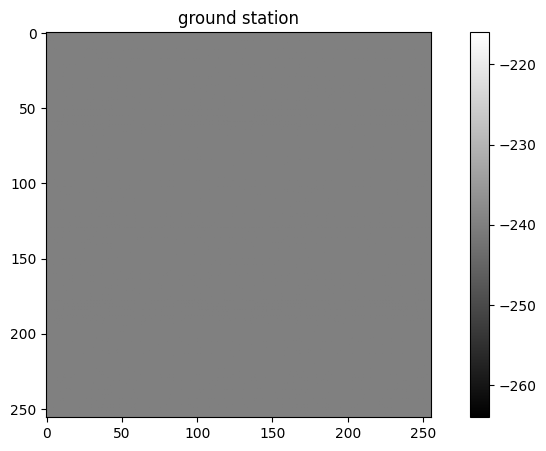

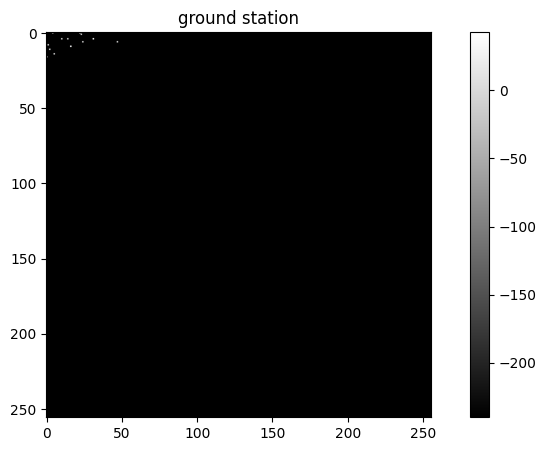

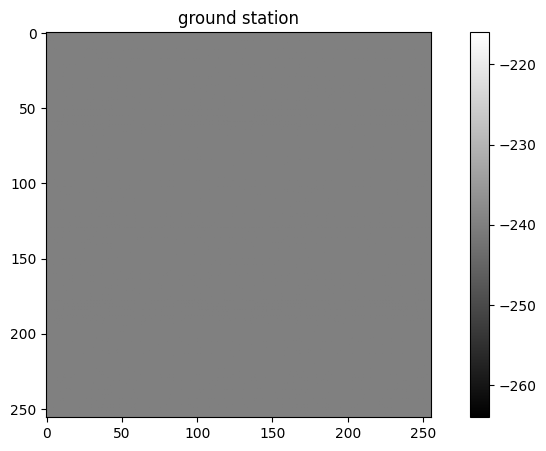

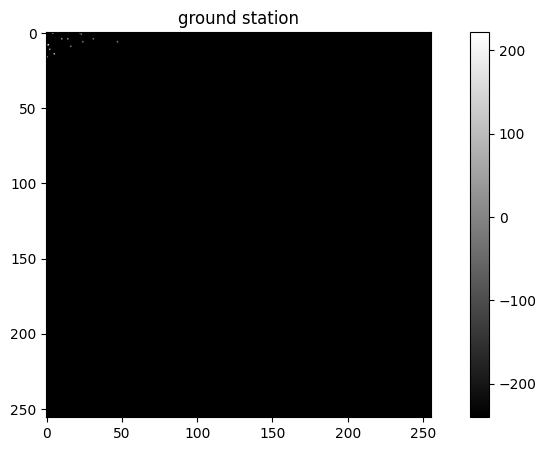

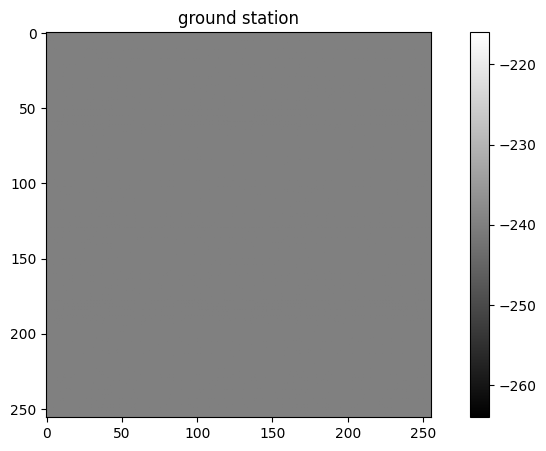

In [18]:
radar_future = data['groundstation_back'] * 60

# we plot the radar_future and the radar_future
for i in range(radar_future.shape[0]):
    plt.figure(figsize=(10, 5))
    plt.imshow(radar_future[i, :, :, 0], cmap='gray')
    plt.title('ground station')
    plt.colorbar()

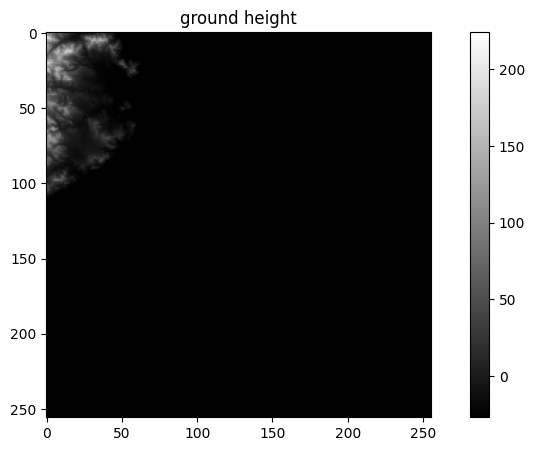

In [19]:
radar_future = data['ground_height'] * 60

# we plot the radar_future and the radar_future
plt.figure(figsize=(10, 5))
plt.imshow(radar_future, cmap='gray')
plt.title('ground height')
plt.colorbar()

In [33]:
radar_future.shape

(256, 256)